# MA2501 - Assignment 2
----
By Markus Valås Hagen, 
Andreas Palm Sivertsen & 
Thomas Wilskow Thorbjørnsen

## Information regarding this project
----
This project wasn't originally written in jupyter but it is ported into this notebook. Please note this if something might have been written in a weird way for being a Jupyter notebook

### Imports
-------

In [63]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import functools
import time

from autograd import jacobian, grad
from operator import mul
from functools import reduce
from math import factorial, floor

# Preliminary Code
----

## Binary Search
----

In [64]:
def binarySearch(array, searchFor):
    """
    Binary search adapted to lower the worst case runtime for pwf from N to lg(N)
    Parameters
    ----------
    array :: [Double]
    searchFor :: Double
    Returns
    ----------
    Returns the index i where search for is greater than array[i], but less than array[i+1], if these exist
    """
    minIndex = 0
    m = len(array) - 1
    maxIndex = m
    midIndex = floor((minIndex + maxIndex)/2)

    while maxIndex >= minIndex:
        midIndex = floor((minIndex + maxIndex)/2)
        
        if midIndex == m:
            return m
        
        v = array[midIndex]

        if searchFor < v:
            maxIndex = midIndex - 1

        elif searchFor > v:
            minIndex = midIndex + 1

        elif searchFor == v:
            return midIndex


    if v <= searchFor <= array[midIndex+1]:
        return midIndex
    return midIndex-1

## Gradients and gradient Descent
----

In [65]:
def meanValDiff(f, a, b):
    """
    One dimensional differentiation based on the mean value theorem
    Parameters
    ----------
    f :: Scalar Function
    a :: Start
    b :: End
    Returns
    ----------
    Returns the derivative of f along the line passing through a and b
    """
    return (f(b)-f(a))/np.linalg.norm(b-a)

def meanValGrad(f, x, h = 1e-14):
    """
    Gradient based on the mean value theorem
    """
    return np.array([meanValDiff(f, np.array([x[j]-h if i == j else x[j] for j in range(len(x))]), np.array([x[j]+h if i == j else x[j] for j in range(len(x))])) for i in range(len(x))])

def gradientDescent(F, x0, γ = 10, ρ = 0.7, σ = 1.3, TOL = 1e-7, maxIter = 100):
    """
    An implementation of gradient descent with backtracking

    Parameters
    ----------
    F :: Scalar function as a Plottable
        The function to optimize
    x0 :: NumPy array of doubles
        Start variable for fixed point iteration
    γ :: Double
        Scaling parameter
    ρ :: Double
        hyperparameter
    σ : Double
        hyperparameter
    TOL :: Double
    maxIter :: Int

    Returns
    ----------
    Returns a NumPy array where F is minimal
    """
    gradF = lambda x : F.grad(x)
    x1 = x0
    φ = F(x1)
    F.history.append(x1)
    for m in range(maxIter):
        # print(f"m:{m}")
        χ = x0
        g = gradF(x1)
        for n in range(maxIter):
            # print(f"n:{n}")
            x1 = x0 - 1/γ*g
            ψ = F(x1)
            if ψ <= φ + np.dot(g,x1-x0)+γ/2*np.linalg.norm(x1-x0)**2:
                x0, φ, γ = x1, ψ, ρ*γ
                break
            else:
                γ = σ*γ
        F.history.append(x1)
        if np.linalg.norm(x1-χ) <= TOL or np.linalg.norm(g) <= TOL:
            break
    return x1

## Function storing, easy plotting and more!
----

In [66]:
class Plottable():
    """
    This is a wrapper for functions, giving them some more structure.
    The nitty gritty of plotting points will be hidden inside this class.
    Attributes
    ----------
    function :: Function
        The function to wrap around
    max_dom :: Double
        Endpoint of plotting
    min_dom :: Double
        Startpoing of plotting

    Methods
    ----------
    plot(start = None, end = None, step = 50)
        You can input your own interval with start and end,
        and adjust the amount of points to plot with step
    diff(n)
        differentiate function n times if possible using autograd
    Operators
    ----------
    () - Call
        Can use parantheses to pass arguments to function
    print()
        Can use print to create and show plot
    """
    __slots__ = ["function", "max_dom", "min_dom", "history", "grad"]

    def __init__(self, function=lambda x: 0, mi=0, ma=1):
        """
        Class constructor, with a default constructor which constructs the 0-function on [0,1].
        Parameters
        ----------
        function :: Function
            The function to wrap
        mi :: Double
            Start of interval
        ma :: Double
            End of interval
        """
        self.function, self.max_dom, self.min_dom, self.history, self.grad = function, ma, mi, [], self.diff

    def plot(self, *args, start=None, end=None, step=500, **kwargs):
        """
        Plots the wrapped function within it's interval.
        Parameters
        ----------
        *args :: ???
            Arguments from plt.plot() which are not the lists to plot,
        start :: Double
            Start of interval to plot on, defaults to min_dom
        end :: Double
            End of interval to plot on, defaults to max_dom
        step :: Int
            How many points to calculate
        **kwargs :: ???
            Keywordarguments from plt.plot
        """
        if start == None or end == None:
            xs = np.linspace(self.min_dom, self.max_dom, step)
            ys = list(map(self.function, xs))
        else:
            xs = np.linspace(start, end, step)
            ys = list(map(self.function, xs))
        plt.plot(xs, ys, *args, **kwargs)

    def __repr__(self):  # Class representation
        plt.figure()
        self.plot()
        plt.show()

    def __call__(self, *args):  # Function calling overloading
        return self.function(*args)

    def diff(self, x):
        """
        Differentiation method using jacobian from autograd
        Parameters
        ----------
        n :: Int
            Number of times to differentiate the wrapped function
        Returns
        ----------
        Returns the differentiated function
        """
        return grad(self.function)(x)

class AltDiff(Plottable):

    def __init__(self, f, start, end, newDiff = None):
        super().__init__(f, start, end)
        if newDiff == None:
            self.grad = self.diff
        else:
            self.grad = newDiff

    def diff(self):
        return lambda x: meanValGrad(self.function, x, h = 1e-4)

## Nodespreads
----

In [67]:
def equiX(a,b,N):
    return np.array([a+i*(b-a)/N for i in range(N+1)])

def chebyX(start, end, steps):
  return [(end - start) / 2 * (np.cos(np.pi * (2 * x + 1) / (2 * steps))) + (end + start) / 2 for x in range(steps)]

def equiNode(start, end, step, f=(lambda x: 0)):
    """
    Creation of equidistant nodes with respect to distances of x's
    Parameters
    ----------
    start :: Double
        start of interval
    end :: Double
        end of interval
    step :: Double
        number of steps
    f :: Function
        A function to distribute the y-values on
    Returns
    ----------
    A list of (x,y)
    """
    xs = np.linspace(start, end, step)
    ys = map(f, xs)
    return [a for a in zip(xs, ys)]


def chebyNode(start, end, steps, f=lambda x: 0):
    """
    Creation of Chebyshev nodes with respect to the distance of the x's
    Parameters
    ----------
    start :: Double
        start of interval
    end :: Double
        end of interval
    step :: Double
        size of each step
    f :: Function
        A function to distribute the y-values on
    Returns
    ----------
    A list of (x,y)
    """
    xs = [(end - start) / 2 * (np.cos(np.pi * (2 * x + 1) / (2 * steps))) + (end + start) / 2 for x in range(steps)]
    ys = map(f, xs)
    return [(x, y) for (x, y) in zip(xs, ys)]

## Test functions
----

In [68]:
# This is supposed to be defined on [0,1]
def a(x):
    return np.cos(2 * np.pi * x)

# This is supposed to be defined on [0,π/4]
def b(x):
    return np.exp(3 * x) * np.sin(2 * x)

def runge(x):
    """
    The runge function
    Parameters
    ----------
    x :: Double
        The value to evaluate in
    Returns
    ----------
    Returns the evaluation at x
    """
    return 1 / (x ** 2 + 1)

def exfunc(x):
    return (3/4)*(np.exp((-1/4)*(9*x - 2)**2) + np.exp((-1/49)*(9*x + 1)**2)) + (1/2)*np.exp((-1/4)*(9*x - 7)**2) - (1/10)*np.exp(-(9*x - 4)**2)

# Lagrange Interpolation
----

## Lagrange Interpolation
----


In [69]:
class Lagrange(Plottable):
    """
    A wrapper for the Lagrange Polynomial of a given set of points.
    The polynomial is generated at construction.
    Super-class
    ----------
    Plottable - Important changes
        Attributes
        ----------
        function :: Function
            This is the Lagrange polynomial
    Attributes
    ----------
    points :: [(x,y)]
        A list of tuples
    Methods
    ----------
    sep()
        Separates the tuples in the list and returns the new list
    """
    __slots__ = ["points"]

    # Strangely enough the way this Lagrange Polynomial is defined is well defined within autograd!
    # How do I comment on this thingy mac-jiggy???
    def __init__(self, plist):
        """
        Class constructor, not equipped with a default constructor.
        Parameters
        ----------
        plist :: [(x,y)]
            A list of tuples to do the interpolation over
        """
        self.points = plist
        xs, ys = self.sep()
        self.max_dom, self.min_dom = max(xs), min(xs)
        # Everything above should make sense, everything below is a clusterfuck
        if len(xs) == 1:
            self.function = lambda x: ys[0]
        else:
            λj = lambda j, ls, x: ys[j] * reduce(mul, [(x - arg) / (ls[j] - arg) for arg in ls if ls[j] != arg])
            self.function = lambda x: sum([λj(i, xs, x) for i in range(len(xs))])

    def sep(self):
        """
        Separates the points in the list.
        Returns
        ----------
        Returns two list, one consisting of x-coordinates, the other of y-coordinates
        """
        return [p[0] for p in self.points], [p[1] for p in self.points]

## Spline Interpolation
----

In [70]:
class PiecewiseLagrange(Lagrange):
    """
    A wrapper for lagrange functions defined on several intervals piecewise.
    Super-Class
    ----------
    Plottable -> Lagrange - Important changes
        Attributes
        ----------
        function :: Function
            This is the piecewise Lagrange Polynomial

    Attributes
    ----------
    functions :: [Function]
        A list of Lagrange Polynomials
    intervals :: [(Double, Double)]
        A list of min_dom and max_dom for every Lagrange Polynomial, respectively
    NB: There is a 1-1 correspondance between functions and intervals defined in the canonical way
    Methods
    ----------
    sep() - overloaded
        This returns a list of separations for every Lagrange Polynomial
    nfunction(x)
        This is simply the "direct sum" of each Lagrage Polynomial on it's interval.
        It is extended to -inf and inf on the endpoints

    """
    __slots__ = ["functions", "interval"]

    def __init__(self, pinterval):
        """
        Constructor for this class, has no default constructor.
        This function just does the Lagrange interpolation on the given subintervals.
        Parameters
        ----------
        pinterval :: [[(x,y)]]
            A list of lists of objects from the class 
        """
        self.points = pinterval
        self.functions = [Lagrange(plist) for plist in pinterval]  # This is where we do the lagrange
        self.interval = [(lambda x: (min(x), max(x)))(l.sep()[0]) for l in self.functions]  # Defining the start and end of each Polynomial
        self.function = lambda x: self.nfunction(x)  # "Gluing" the polynomials together, extending the ends
        self.min_dom, self.max_dom = self.interval[0][0], self.interval[-1][1]  # Then setting the total start and endpoint to be the start of the first and end of the last function

    def sep(self):
        """
        An overload of the seperation method.
        Returns
        ----------
        Returns a list of tuples of seperations for each given interval
        """
        return [p.sep() for p in functions]

    def nfunction(self, x):
        """
        The piecewise Lagrange Polynomial
        Parameters
        ----------
        x :: Double??? #It seems Python has no well-definedness for function types
            This argument is determined by the functions input
        Returns
        ----------
        Returns the value of the piecewise Lagrange Polynomial evaluated at x
        """
        if x < self.interval[0][1]:
            return self.functions[0](x)
        for i in range(1, len(self.interval) - 1):
            (m, n) = self.interval[i]
            if m < x and x < n:
                return self.functions[i](x)
        return self.functions[-1](x)

## Optimization of Lagrange Interpolation
----

In [71]:
class DescentLagrange(Plottable):
    """
    A wrapper for Lagrange polynomials where we know some points of the function.

    Super-Class
    ----------
    Plottable -> Lagrange

    Attributes
    ----------
    map :: {Double, Double}
        A dictionary of the known values (See Map object)
    keys :: [Double]
        The keys to the dictionary
    n :: Int
        Number of interpolation nodes
    N :: Int
        Number of known points of the function

    Method
    ----------
    cost(points)
        Calculates a cost of producing the Lagrange polynomial with the given set of points
    """

    __slots__ = ["xsKnown", "ysKnown", "N", "n"]

    def __init__(self, known, n):
        self.n = n
        self.xsKnown, self.ysKnown = np.array([x for x,_ in known]), np.array([y for _,y in known])
        self.min_dom, self.max_dom, self.N = min(self.xsKnown), max(self.xsKnown), len(self.xsKnown)

        def cost(xs):
            p = self.inter(xs)
            const = (self.max_dom-self.min_dom)/self.N
            s = 0
            for x in self.xsKnown:
                s = s + (self.pwf(x)-p(x))**2
            return const*s
        
        cp = AltDiff(cost, None, None, lambda x: meanValGrad(cost, x))

        startNodes = equiX(self.min_dom, self.max_dom, self.n)
        bestNodes = gradientDescent(cp, startNodes)
        self.function = self.inter(bestNodes)
        self.history = cp.history

    @functools.lru_cache(256)
    def pwf(self, x):
        i = binarySearch(self.xsKnown, x)
        if i >= self.N-1:
            i = self.N-2
        a = (self.ysKnown[i+1]-self.ysKnown[i])/(self.xsKnown[i+1]-self.xsKnown[i])
        return a*x+self.ysKnown[i]-a*self.xsKnown[i]

    def inter(self, xs):
        ys = list(map(self.pwf, xs))
        λj = lambda j, ls, x: ys[j]*reduce(mul, [(x-arg)/(ls[j]-arg) for arg in ls if ls[j] != arg])
        return lambda x: sum([λj(i, xs, x) for i in range(len(xs))])

#### Optimization of Lagrange interpolation with known function
----

In [72]:
class DescentLagrangeLegacy(Plottable):
    """
    A wrapper for Lagrange polynomials where we know some points of the function.
    Super-Class
    ----------
    Plottable -> Lagrange
    Attributes
    ----------
    map :: {Double, Double}
        A dictionary of the known values (See Map object)
    keys :: [Double]
        The keys to the dictionary
    n :: Int
        Number of interpolation nodes
    N :: Int
        Number of known points of the function
    Method
    ----------
    cost(points)
        Calculates a cost of producing the Lagrange polynomial with the given set of points
    """

    __slots__ = ["f", "xsKnown", "N", "n"]

    def __init__(self, f, xsKnown, n):
        self.f, self.xsKnown = f, xsKnown
        self.min_dom, self.max_dom, self.N = min(xsKnown), max(xsKnown), len(xsKnown)
        self.n = n

        def cost(xs):
            p = self.inter(xs)
            return (self.max_dom-self.min_dom)/self.N*sum([(self.f(x)-p(x))**2 for x in self.xsKnown])
        
        cc = AltDiff(cost, 0, 1, lambda x: meanValGrad(cost, x))

        bestNodes = gradientDescent(cc, equiX(self.min_dom, self.max_dom, self.n), 10)
        self.function = self.inter(bestNodes)

    def inter(self, xs):
        ys = self.f(xs)
        λj = lambda j, ls, x: ys[j]*reduce(mul, [(x-arg)/(ls[j]-arg) for arg in ls if ls[j] != arg])
        return lambda x: sum([λj(i, xs, x) for i in range(len(xs))])

# Radial Basis Function Interpolation
----

In [73]:
def coq(f, N, a, b):
    """
    Global variable declaration
    Parameters
    ----------
    f :: Function 
        The function to interpolate (used in the cost function and get_W)
    N :: Int
        Number of steps in the cost function
    a :: Int
        Start of nodes
    b :: Int
        End of nodes
    """
    coq.f, coq.N, coq.a, coq.b = f, N, a, b

def phi(r,e=3):
    """
    Phi function used in RBF interpolation
    Parameters
    ----------
    r :: Float
        phi(abs(x-x)), r=abs(x-xi)
    e :: Float
        Shape parameter
    Returns
    ----------
    Returns the calculated double
    """
    return np.exp(-(e * r) ** 2)
    

def Get_w(x, e=3):
    """
    Computes the vector w used in the interpolation
    Parameters
    ----------
    x :: np.array(Double)
        Nodes to interpolate, with the shape parameter as the last entry
    e :: float
        Shape parameter, often just x[-1]
    Returns
    ----------
    Returns a NumPy array of doubles of the weights to apply in interpolation
    """
    M = np.array([[phi(abs(x[i]-x[j]),e) for j in range(len(x)-1)] for i in range(len(x)-1)], dtype = float)
    f_vec = np.array([coq.f(x[i]) for i in range(len(x)-1)])
    ws = np.linalg.solve(M, f_vec)
    return ws

def interpolation(xs):
    """
    This is the interpolated function
    Paramters
    ----------
    xs :: np.array(Double)
        array of points to interpolate over with the shape parameter as the last entry
    Returns
    ----------
    Returns a function of the interpolation
    """
    ws = Get_w(xs,xs[-1])
    return lambda x: sum([ws[i]*phi(abs(x-xs[i]),xs[-1]) for i in range(len(xs)-1)])


def cost_int(xs):
    """
    Return the cost of the function
    Parameters
    ----------
    xs :: np.array(Double)
        nodes to interpolate, withe the shape parameter as the last entry
    Returns
    ----------
    Returns a double of the cost of the interpolation 
    """
    
    xis = np.array(equiX(coq.a, coq.b, coq.N))
    g = interpolation(xs)
    s = 0
    for i in range(coq.N):
        s = s + (coq.f(xis[i])-g(xis[i]))**2
    return ((coq.b-coq.a)/coq.N)*s

# Error Calculations
----

## Virtual Error Calculation class
----

In [74]:
class ErrorCompare(Plottable):
    """
    This class will act as the base for the comparisons method for the errors of the Lagrange polynomials.
    This is meant to be a generic, virtual class, so some of the functions might be missing, but defined.
    Super-Class
    ----------
    Plottable - Important changes
        Attributes
        ----------
            function :: Function
                This is the true function we want to approximate
    Attributes
    ----------
    sqErr :: [Double]
        List of error-value of the 2-norm
    supErr :: [Double]
        List of error-values of the sup-norm
    N :: Int
        maximal number of iterations
    Methods
    ----------
    genny(steps = None)
        A virtual method to generate different approximations
    err2(n)
        A method to find 2-norm error based on genny()
    errSup(n)
        A method to find sup-nomr error based on genny()
    plot() - changed
        plot now plots both 2Err and supErr
    """
    __slots__ = ["sqErr", "supErr", "N"]

    def __init__(self, function, mi, ma, n=10):
        """
        Class Constructor, has no default constructor.
        Parameters
        ----------
        function :: Function
            The true function to approximate
        mi :: Double
            start of test domain
        ma :: Double
            end of test domain
        n :: Int
            number of iterations to run
        """
        super().__init__(function, mi, ma)

    @functools.lru_cache(256)
    def genny(self, steps=None):
        """
        This is simply a virtual method to generate approximations.
        Parameters
        ----------
        steps :: Int
            The amount of steps to take in the approx
        Returns
        ----------
        This function returns None as it is virtual
        """
        return None

    def err2(self, n, k):
        """
        A method to find the 2-norm error of the approximation on the test interval.
        Parameters
        ----------
        n :: Int
            The amount of nodes to interpolate on
        k :: Int
            virtual variable - aka. genny() magic
        Returns
        ----------
        Returns the 2-norm error
        """
        p, f = [P[1] for P in equiNode(self.min_dom, self.max_dom, 100 * n, self.genny(steps=k).function)], [P[1] for P in equiNode(self.min_dom, self.max_dom, 100 * n, self.function)]
        return np.sqrt((self.max_dom - self.min_dom) / (100 * n) * sum([(y - x) ** 2 for (x, y) in zip(p, f)]))

    def errSup(self, n, k):
        """
        A method to find the sup-norm error of the approximation on the test interval.

        Parameters
        ----------
        n :: Int
            The amount of nodes to interpolate on
        k :: Int
            virtual variable - aka. genny() magic

        Returns
        ----------
        Returns the sup-norm error
        """
        p, f = [P[1] for P in equiNode(self.min_dom, self.max_dom, 100 * n, self.genny(steps=k).function)], [P[1] for P in equiNode(self.min_dom, self.max_dom, 100 * n, self.function)]
        return max([abs(y - x) for (x, y) in zip(p, f)])

    def plot(self, *args, **kwargs):
        '''Ploting the 2-norm and sup-norm as a function of the number of interpolations points used.'''
        plt.semilogy(range(2, self.N + 1), self.sqErr, *args, label="Square Error", *kwargs)
        plt.semilogy(range(2, self.N + 1), self.supErr, *args, label="Sup Error", *kwargs)
        plt.legend()

    def plot2(self, *args, **kwargs):
        plt.semilogy(range(2, self.N + 1), self.sqErr, *args, label=f"Square Error with {self.v}nodes", *kwargs)
        plt.legend()

## Error of Lagrange Interpolation
----

In [75]:
class ErrorLagrange(ErrorCompare):
    """
    Class for comparing the Lagrange Polynomial to the original function.
    Super-Class
    ----------
    Plottable -> ErrorCompare
    Attributes
    ----------
    v :: String
        The type of node-spread (Equidistant or Chebyshev)
    Methods
    ----------
    genny(steps = None) - overloaded
        A generator function for finding a fitting Lagrange Polynomial based on the string v
    """
    __slots__ = ["v"]

    def __init__(self, function, mi, ma, n=20, v="Equi"):
        """
        Class constructor, has not a default constructor.
        Parameters
        ----------
        function :: Function
            The function to approximate with Lagrange Interpolation
        mi :: Double
            start of test interval
        ma :: Double
            end of test interval
        n :: Int
            number of steps to take
        v :: String
            The type of node-spread to use. Can have "Equi" or "Cheby" as input, else it will raise an execption
        """
        super().__init__(function, mi, ma, n)
        self.v = v
        self.N = n
        self.sqErr, self.supErr = [self.err2(self.N, m) for m in range(1, n)], [self.errSup(self.N, m) for m in range(1, n)]

    @functools.lru_cache(256)
    def genny(self, steps=None):
        """
        The generator function for the Lagrange Polynomial.
        Parameters
        ----------
        steps :: Int
            number of steps to take
        Returns
        ----------
        Returns the Lagrange Polynomial with degree steps-1
        """
        if steps == None:
            steps = self.N
        if self.v == "Equi":
            return Lagrange(equiNode(self.min_dom, self.max_dom, steps, self.function))
        if self.v == "Cheby":
            return Lagrange(chebyNode(self.min_dom, self.max_dom, steps, self.function))
        raise TypeError("Not a valid node-spread")

## Error of Spline Interpolation
----

In [76]:
class ErrorPiecewiseLagrange(ErrorCompare):
    """
    Class for comparing the piecwise Lagrange Polynomial to the original function.
    Super-Class
    ----------
    Plottable -> ErrorCompare
    Attributes
    ----------
    K :: Int
        The maximum amount of intervals to interpolate on
    Methods
    ----------
    genny(steps = None) - overloaded
        A generator function for finding a fitting piecewise Lagrange Polynomial based on the amount of intervals
    plot() - overloaded
        plotting is overloaded to handle intervals rather than interpolation points
    """
    __slots__ = ["K", "extras"]

    def __init__(self, function, mi, ma, n=10, k=10):
        """
        Class constructor, has no defualt constructor
        Parameters
        ----------
        function :: Function
            The true function to approximate
        mi :: Double
            start of test interval
        ma :: Double
            end of test interval
        n :: Int
            the exact amount of interpolation nodes in each interval
        k :: the maximum amount of intervals
        """
        super().__init__(function, mi, ma)
        self.N, self.K = n, k
        self.extras = [[self.errSup(self.N, (k+2, np)) for k in range(self.K)] for np in range(1,11)]
        self.supErr = [self.errSup(self.N, (k+2, self.N)) for k in range(self.K)]  # Fiks dette Thomas!

    def genny(self, steps=None):
        """
        The generator function for the piecewise Lagrange Polynomial with equidistant nodes.
        Parameter
        ----------
        k :: Int
            The amount of intervals to use
        Returns
        ----------
        Returns the piecewise Lagrange Polynomial
        """
        intervals = np.linspace(self.min_dom, self.max_dom, steps[0])
        intervals = [(intervals[i], intervals[i + 1]) for i in range(len(intervals) - 1)]
        pintervals = [equiNode(mi, ma, steps[1], self.function) for (mi, ma) in intervals]
        return PiecewiseLagrange(pintervals)

    def extraplot(self, *args, **kwargs):
        for i in range(len(self.extras)):
            plt.semilogy([k for k in range(1, self.K+1)], self.extras[i], *args, label = f"Sup Error with n ={i+1}", **kwargs)
        plt.legend()

    def plot(self, *args, **kwargs):
        '''This is overloaded as we're plotting with another variable than the number of interpolation points'''
        # plt.semilogy(range(2, self.K+2), self.sqErr, label = "Square Error")
        plt.semilogy([self.N * i for i in range(1, self.K + 1)], self.supErr, *args, label=f"Sup Error with n={self.N}", **kwargs)
        plt.legend()

## Error of Optimized Lagrange
----

In [77]:
class ErrorDescent(ErrorCompare):
    """
    Class for comparing the Optimized Lagrange Interpolation with the original function
    Super-Class
    ----------
    Plottable -> ErrorCompare
    Attributes
    ----------
    v :: String
        The type of node-spread to start with (Not fully implemented)
    knownEqui :: [(Double,Double)]
        A list of the points we know
    Methods
    ----------
    genny(steps = None) - overloaded
        A generator function for finding fitting interpolations
    plot() - Overloaded
            This only plots the relevant data
    """

    __slots__ = ["v", "knownEqui"]

    def __init__(self, f, mi, ma, N = 1000, v = "Equi"):
        """
        Class constructor, has no default constructor
        Parameters
        ----------
        f :: Function
            The function to approximate
        mi :: Double
            start of test interval
        ma :: Double
            end of test interval
        N :: Int
            number of known nodes
        v :: nodespread
            not yet fully implemented
        """
        self.function, self.min_dom, self.max_dom, self.N = f, mi, ma, N
        self.knownEqui = equiNode(mi, ma, N, f)
        self.v = "Equi"
        self.sqErr = [self.err2(self.N, k) for k in range(1,20)]


    def genny(self, steps = 1):
        """
        The generator function
        Parameters
        ----------
        steps :: Int
            The amount of nodes to interpolate with
        Returns 
        ----------
        Returns an optimized Lagrange polynomial
        """
        if self.v == "Equi":
            return DescentLagrange(self.knownEqui, steps)
        elif self.v == "Cheby":
            return DescentLagrange(self.function, self.knownCheby, steps)
        return None

    def plot(self, *args, **kwargs):
        """
        function for plotting, overloaded from Plottable
        Parameters
        ----------
        *args :: *args
            arguments from plt.plot()
        **kwargs :: **kwargs
            keywordarguments from plt.plot()
        """
        plt.semilogy(range(2, 21), self.sqErr, *args, label="Descent - Square Error", *kwargs)
        plt.legend()

### Error of Optimized Lagrange when the function is known
----

In [78]:
class ErrorDescentLegacy(ErrorCompare):
    """
    Class for comparing the Optimized Lagrange Interpolation with the original function
    Super-Class
    ----------
    Plottable -> ErrorCompare
    Attributes
    ----------
    v :: String
        The type of node-spread to start with (Not fully implemented)
    knownEqui :: [(Double,Double)]
        A list of the points we know
    Methods
    ----------
    genny(steps = None) - overloaded
        A generator function for finding fitting interpolations
    plot() - Overloaded
            This only plots the relevant data
    """

    __slots__ = ["v", "knownEqui"]

    def __init__(self, f, mi, ma, N = 1000, v = "Equi"):
        """
        Class constructor, has no default constructor
        Parameters
        ----------
        f :: Function
            The function to approximate
        mi :: Double
            start of test interval
        ma :: Double
            end of test interval
        N :: Int
            number of known nodes
        v :: nodespread
            not yet fully implemented
        """
        self.function, self.min_dom, self.max_dom, self.N = f, mi, ma, N
        self.knownEqui = equiX(mi, ma, N)
        self.v = "Equi"
        self.sqErr = [self.err2(self.N, k) for k in range(1,20)]


    def genny(self, steps = 1):
        """
        The generator function
        Parameters
        ----------
        steps :: Int
            The amount of nodes to interpolate with
        Returns 
        ----------
        Returns an optimized Lagrange polynomial
        """
        if self.v == "Equi":
            return DescentLagrangeLegacy(self.function, self.knownEqui, steps)
        elif self.v == "Cheby":
            return DescentLagrangeLegacy(self.function, self.knownCheby, steps)
        return None

    def plot(self, *args, **kwargs):
        """
        function for plotting, overloaded from Plottable
        Parameters
        ----------
        *args :: *args
            arguments from plt.plot()
        **kwargs :: **kwargs
            keywordarguments from plt.plot()
        """
        plt.semilogy(range(2, 21), self.sqErr, *args, label="Descent Legacy - Square Error", *kwargs)
        plt.legend()

## Error of Radial Basis Function Interpolation
----

In [79]:
class ErrRBF(ErrorCompare):
    """
    Class for comparing the Radial Basis Function Interpolation to the true function
    Super-Class
    ----------
    Plottable -> ErrorCompare
    Attributes
    ----------
    a :: Int
        A variable acting as the switch argument in other programming languages
    b :: [Double]
        List of 2 norm error for non-optimized RBF Interpolation
    Methods
    ----------
    genny(steps = None) - overloaded
        A generator functionfor finding fitting interpolations
    plot() - overloaded
        This only plots relevant data
    """

    __slots__ = ["a","b"]
    def __init__(self, f, mi, ma, n = 10):
        """
        Class constructor, has no defualt constructor
        Paramters
        ----------
        f :: Function
            A real function
        mi :: Double
            start of test intervall
        ma :: Double
            end of test intervall
        n :: Int
            the amount of nodes to interpolate on
        """
        super().__init__(f, mi ,ma, n)
        self.N = n
        self.a = 0
        self.sqErr = [self.err2(self.N,h+1) for h in range(2,n+1)]
        self.a = 1
        self.b = [self.err2(self.N, h+1) for h in range(2,n+1)]

    def genny(self, steps=None):
        """
        The generator function
        Parameters
        ----------
        steps = None
            the amount of interpolation nodes
        Returns
        ----------
        Returns the fitting interpolation
        """
        coq(self.function, steps, self.min_dom, self.max_dom)
        xs = equiX(self.min_dom,self.max_dom,steps)
        tallet_3 = np.array([3])
        xs = np.hstack((xs,tallet_3)) #This is for testing different start points of the shape parameter
#        xs = chebyX(self.min_dom,self.max_dom,steps)
        if self.a == 0:
            ci = Plottable(cost_int, None, None)
            nodes = gradientDescent(ci, xs)
            g =interpolation(nodes)
            return Plottable(g,self.min_dom,self.max_dom)
        elif self.a == 1:
            g = interpolation(xs)
            return Plottable(g,self.min_dom,self.max_dom)

    def plot(self, *args, **kwargs):# '''This is overloaded as we're plotting with another variable than the number of interpolation points'''
        # plt.semilogy(range(2, self.K+2), self.sqErr, label = "Square Error")
        plt.semilogy([i for i in range(2, self.N + 1)],self.sqErr, *args, label="sqrt Error grad Descent", **kwargs)
        plt.semilogy([i for i in range(2, self.N + 1)], self.b, *args, label="sqrt Error  w/o grad Descent", **kwargs)
        plt.legend()

# Task Completions
----

## Task i
----

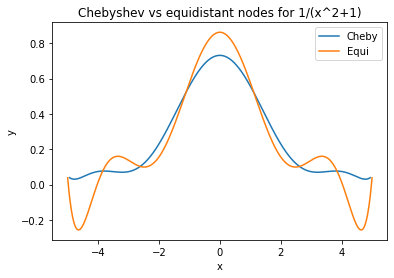

In [80]:
plt.figure()
plt.axes(xlabel = "x", ylabel = "y")
r = Lagrange(chebyNode(-5, 5, 10, runge))
r.plot(label = "Cheby")
p = Lagrange(equiNode(-5, 5, 10, runge))
p.plot(label = "Equi")
plt.title("Chebyshev vs equidistant nodes for 1/(x^2+1)")
plt.legend()
plt.show()

## Task ii
----

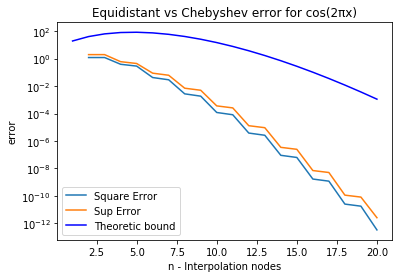

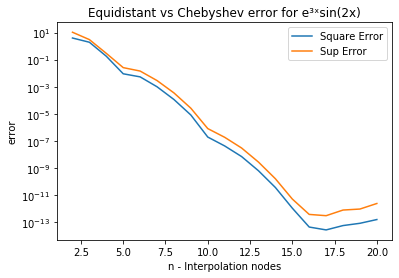

In [81]:
plt.figure()
plt.axes(xlabel = "n - Interpolation nodes", ylabel = "error")
v = ErrorLagrange(a, 0, 1, n = 20) #Interpolating the first function
v.plot()
(lambda ns: plt.plot(ns, list(map(lambda n: (2*np.pi)**(n+1)/factorial(n+1), ns)), 'b', label = "Theoretic bound"))(range(1,21)) # Plotting the theoretic bound
plt.title("Equidistant vs Chebyshev error for cos(2πx)")
plt.legend()
plt.show()
plt.figure()
plt.axes(xlabel = "n - Interpolation nodes", ylabel = "error")
u = ErrorLagrange(b, 0, np.pi/4, 20) #Interpolating the second function
u.plot()
plt.legend()
plt.title("Equidistant vs Chebyshev error for e³ˣsin(2x)")
plt.show()

## Task iii
----

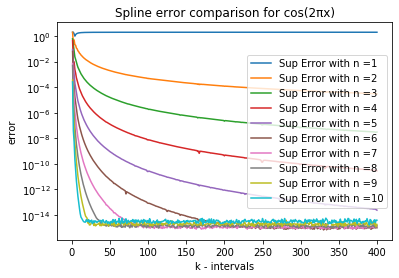

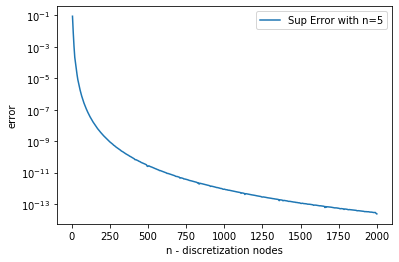

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure()
plt.axes(xlabel = "k - intervals", ylabel = "error")
u = ErrorPiecewiseLagrange(a, 0, 1, 5, 400)
u.extraplot()
plt.title("Spline error comparison for cos(2πx)")
plt.show()

plt.figure()
plt.axes(xlabel = "n - discretization nodes", ylabel = "error")
u.plot()
plt.figure("Spline error decresing for n = 5 and cos(2πx)")
plt.show()

### Extra plots
----

Done with 6 intervals
Done with 5 intervals
Done with 4 intervals
Done with 3 intervals
Done with 2 intervals
Done with 1 intervals


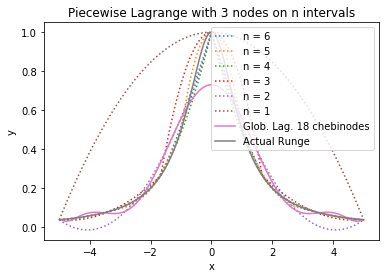

In [83]:
def pint(f, start, slutt, noder, steps):
  intervals = np.linspace(start, slutt, steps)
  intervals = [(intervals[i], intervals[i + 1]) for i in range(len(intervals) - 1)]
  return [equiNode(mi, ma, noder, f) for (mi, ma) in intervals]

plt.figure()
plt.axes(xlabel = "x", ylabel= "y")

rung5 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,7))
rung5.plot(":",step=5000, label= "n = 6")

print("Done with 6 intervals")

rung5 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,6))
rung5.plot(":",step=5000, label= "n = 5")

print("Done with 5 intervals")

rung4 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,5))
rung4.plot(":",step=5000, label= "n = 4")

print("Done with 4 intervals")

rung3 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,4))
rung3.plot(":",step=5000, label= "n = 3")

print("Done with 3 intervals")

rung2 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,3))
rung2.plot(":",step=5000, label= "n = 2")

print("Done with 2 intervals")

rung1 = PiecewiseLagrange(pint(runge,-5.0,5.0,3,2))
rung1.plot(":",step=5000, label= "n = 1")

print("Done with 1 intervals")

c = Lagrange(chebyNode(-5, 5, 10, runge))
c.plot(label = "Glob. Lag. 18 chebinodes")

r = Plottable(runge, -5, 5)
r.plot(step=5000, label="Actual Runge")
plt.title("Piecewise Lagrange with 3 nodes on n intervals")
plt.legend()
plt.show()

## Task iv
----

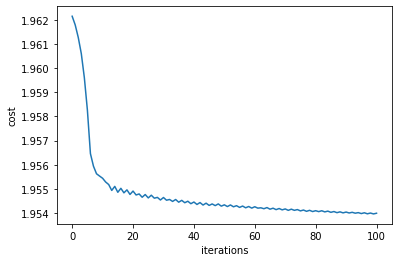

In [84]:
ls = equiNode(0,1,10,a)
h = DescentLagrange(ls,10)
plt.figure()
plt.axes(xlabel = "iterations", ylabel = "cost")
plt.plot(list(map(np.linalg.norm, h.history)))
plt.show()

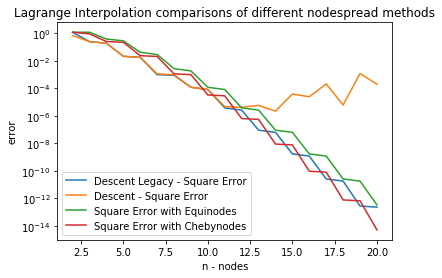

In [85]:
d = ErrorDescentLegacy(a, 0, 1)
e = ErrorDescent(a, 0, 1)
q = ErrorLagrange(a, 0, 1)
r = ErrorLagrange(a, 0, 1, v = "Cheby")
plt.figure()
plt.axes(xlabel = "n - nodes", ylabel = "error")
d.plot()
e.plot()
q.plot2()
r.plot2()
plt.title("Lagrange Interpolation comparisons of different nodespread methods")
plt.show() 

## Task v
----

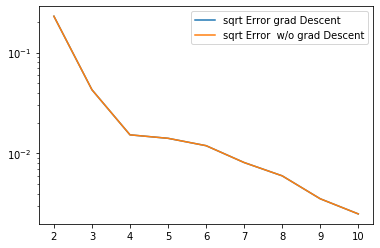

In [86]:
plt.figure()
u = ErrRBF(runge,-1,1,10)
u.plot()
plt.show()